# Importing Libraries

In [1]:
import pandas as pd 
import re
import numpy as np
import skfuzzy as fuzz
import nltk
from nltk.corpus import stopwords
#!pip install seaborn
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np

np.random.seed(1337)  # for reproducibility
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from dbn import SupervisedDBNClassification


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/stark/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading  Dataset

In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",delimiter=',',encoding='latin-1')

In [3]:
df.reset_index(drop=True,inplace=True)

# Selection of the interested columns for feature extraction 

In [4]:
z = df.iloc[:,0]

In [5]:
z.unique()

array([0, 4])

In [6]:
X =  df.iloc[:,1]
Y = df.iloc[:,-1]
Y

0          is upset that he can't update his Facebook by ...
1          @Kenichan I dived many times for the ball. Man...
2            my whole body feels itchy and like its on fire 
3          @nationwideclass no, it's not behaving at all....
4                              @Kwesidei not the whole crew 
                                 ...                        
1599994    Just woke up. Having no school is the best fee...
1599995    TheWDB.com - Very cool to hear old Walt interv...
1599996    Are you ready for your MoJo Makeover? Ask me f...
1599997    Happy 38th Birthday to my boo of alll time!!! ...
1599998    happy #charitytuesday @theNSPCC @SparksCharity...
Name: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, Length: 1599999, dtype: object

In [7]:
df1 = df.iloc[:,:2]

In [8]:
df1.columns = ["id","text"]

In [9]:
df1.id = X
df1.text = Y

# Count of the dataset

In [10]:
len(df1)

1599999

# Dataset analysis and Preprocessing

In [11]:
def clean(text_):
    
    
    text = text_
    text = text.lower
    #text = [word for word in text if word not in stopwords]
    text = re.sub('<[^<]+?>','', text)
    text = ''.join(c for c in text if not c.isdigit())
    text = ''.join(c for c in text if c not in punctuation)

    wordnet_lemmatizer = WordNetLemmatizer()
  
    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]

      #text = nltk.word_tokenize(text)
  
    return text


# Analyse text wordcloud for the first 50 text

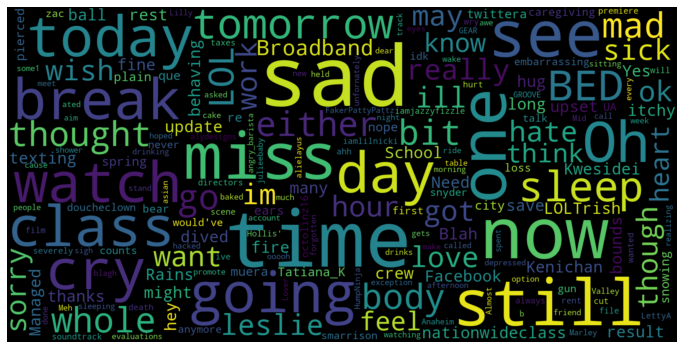

In [12]:
neg = df1.text[:50]
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud random 50 text 

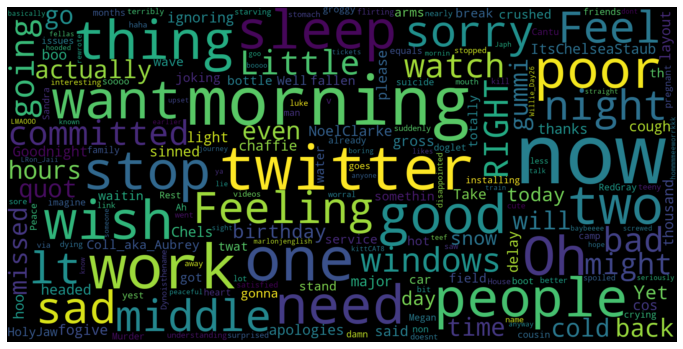

In [13]:
neg = df1.text[1400:1450]
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Intensity Analyzer

In [14]:
sid = SentimentIntensityAnalyzer()
ls = sid.polarity_scores(df1.text[0])
ls



{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'compound': -0.75}

In [15]:
df2 = df1.id.copy()

In [16]:
df_m = df1.iloc[:200]
df_f = df_m.copy()

In [17]:
len(df_m)

200

In [18]:
neg = []
neu = []
pos = []
com = []
#df2["neu"] = df1.id
#df2["pos"] = df1.id

for i in range (len(df_m)):
    ls = sid.polarity_scores(df_m.text[i])
    neg.append(ls['neg'])
    neu.append(ls['neu'])
    pos.append(ls['pos'])
    com.append(ls['compound'])
    

    

In [19]:
df_f["neg"] = neg
df_f["neu"] = neu
df_f["pos"] = pos
df_f["compound"] = com

In [20]:
#df_m["orign"] = z

In [21]:
#z.iloc[:50]

# Generate universe variables 

In [22]:
# Generate universe variables
#   * pos and neg on subjective ranges [0, 1]
#   * op has a range of [0, 10] in units of percentage points
x_p = np.arange(0, 1, 0.1)
x_n = np.arange(0, 1, 0.1)
x_op = np.arange(0, 10, 1)

# Fuzzy logic

In [23]:
# Generate fuzzy membership functions
p_lo = fuzz.trimf(x_p, [0, 0, 0.5])
p_md = fuzz.trimf(x_p, [0, 0.5, 1])
p_hi = fuzz.trimf(x_p, [0.5, 1, 1])
n_lo = fuzz.trimf(x_n, [0, 0, 0.5])
n_md = fuzz.trimf(x_n, [0, 0.5, 1])
n_hi = fuzz.trimf(x_n, [0.5, 1, 1])
op_Neg = fuzz.trimf(x_op, [0, 0, 5])  # Scale : Neg Neu Pos
op_Neu = fuzz.trimf(x_op, [0, 5, 10])
op_Pos = fuzz.trimf(x_op, [5, 10, 10])

In [24]:
sentiment_val=[]
sentiment = []
sentiment_doc=[]
for j in range(len(df_m)):
    #sentiment_doc.append(senti[j])
    ss = sid.polarity_scores(df_m.text[j])
    posscore=ss['pos']
    negscore=ss['neg']
    neuscore=ss['neu']
    compoundscore=ss['compound']
   
    
    
    #print("\nPositive Score for each  tweet :")    
    if (posscore==1):
        posscore=0.9 
    else:
        posscore=round(posscore,1)
    print(posscore)

    #print("\nNegative Score for each  tweet :")
    if (negscore==1):
        negscore=0.9
    else:
        negscore=round(negscore,1)
    #print(negscore)

# We need the activation of our fuzzy membership functions at these values.
    p_level_lo = fuzz.interp_membership(x_p, p_lo, posscore)
    p_level_md = fuzz.interp_membership(x_p, p_md, posscore)
    p_level_hi = fuzz.interp_membership(x_p, p_hi, posscore)
    
    n_level_lo = fuzz.interp_membership(x_n, n_lo, negscore)
    n_level_md = fuzz.interp_membership(x_n, n_md, negscore)
    n_level_hi = fuzz.interp_membership(x_n, n_hi, negscore)
    
    # Now we take our rules and apply them. Rule 1 concerns bad food OR nice.
    # The OR operator means we take the maximum of these two.
    active_rule1 = np.fmin(p_level_lo, n_level_lo)
    active_rule2 = np.fmin(p_level_md, n_level_lo)
    active_rule3 = np.fmin(p_level_hi, n_level_lo)
    active_rule4 = np.fmin(p_level_lo, n_level_md)
    active_rule5 = np.fmin(p_level_md, n_level_md)
    active_rule6 = np.fmin(p_level_hi, n_level_md)
    active_rule7 = np.fmin(p_level_lo, n_level_hi)
    active_rule8 = np.fmin(p_level_md, n_level_hi)
    active_rule9 = np.fmin(p_level_hi, n_level_hi)
    
    # Now we apply this by clipping th  # Now we take our rules and apply them. Rule 1 concerns bad food OR nice.
    # The OR operator means we take the maximum of these two.e top off the corresponding output
    # membership function with `np.fmin`
    
    n1=np.fmax(active_rule4,active_rule7)
    n2=np.fmax(n1,active_rule8)     
    op_activation_lo = np.fmin(n2,op_Neg)
    
    neu1=np.fmax(active_rule1,active_rule5)
    neu2=np.fmax(neu1,active_rule9)     
    op_activation_md = np.fmin(neu2,op_Neu)
    
    p1=np.fmax(active_rule2,active_rule3)
    p2=np.fmax(p1,active_rule6)   
    op_activation_hi = np.fmin(p2,op_Pos)
    
    op0 = np.zeros_like(x_op)
    
    # Aggregate all three output membership functions together
    aggregated = np.fmax(op_activation_lo,
                         np.fmax(op_activation_md, op_activation_hi))
    
    # Calculate defuzzified result
    op = fuzz.defuzz(x_op, aggregated, 'centroid')
    output=round(op,2)

    op_activation = fuzz.interp_membership(x_op, aggregated, op)  # for plot


    

    print("\nFiring Strength of Negative (wneg): "+str(round(n2,4)))
    print("Firing Strength of Neutral (wneu): "+str(round(neu2,4)))
    print("Firing Strength of Positive (wpos): "+str(round(p2,4)))
    
    print("\nResultant consequents MFs:" )
    print("op_activation_low: "+str(op_activation_lo))
    print("op_activation_med: "+str(op_activation_md))
    print("op_activation_high: "+str(op_activation_hi))
    
    print("\nAggregated Output: "+str(aggregated))

    print("\nDefuzzified Output: "+str(output))



    if 0<(output)<4.55:    # R
        print("\nOutput after Defuzzification: Negative")
        sentiment.append("Negative")
        sentiment_val.append('0')
   
    elif 4.56<(output)<10:
        print("\nOutput after Defuzzification: Positive")
        sentiment.append("Positive")
        sentiment_val.append('1')
        
        
        
     

0.0

Firing Strength of Negative (wneg): 0.6
Firing Strength of Neutral (wneu): 0.4
Firing Strength of Positive (wpos): 0.0

Resultant consequents MFs:
op_activation_low: [0.6 0.6 0.6 0.4 0.2 0.  0.  0.  0.  0. ]
op_activation_med: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.2]
op_activation_high: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Aggregated Output: [0.6 0.6 0.6 0.4 0.4 0.4 0.4 0.4 0.4 0.2]

Defuzzified Output: 3.99

Output after Defuzzification: Negative
0.2

Firing Strength of Negative (wneg): 0.0
Firing Strength of Neutral (wneu): 0.6
Firing Strength of Positive (wpos): 0.4

Resultant consequents MFs:
op_activation_low: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
op_activation_med: [0.  0.2 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.2]
op_activation_high: [0.  0.  0.  0.  0.  0.  0.2 0.4 0.4 0.4]

Aggregated Output: [0.  0.2 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.4]

Defuzzified Output: 4.98

Output after Defuzzification: Positive
0.2

Firing Strength of Negative (wneg): 0.6
Firing Strength of Neutral (wneu): 0.4
Firing S

op_activation_low: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
op_activation_med: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.2]
op_activation_high: [0.  0.  0.  0.  0.  0.  0.2 0.4 0.6 0.6]

Aggregated Output: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.6 0.6]

Defuzzified Output: 5.26

Output after Defuzzification: Positive
0.0

Firing Strength of Negative (wneg): 0.0
Firing Strength of Neutral (wneu): 1.0
Firing Strength of Positive (wpos): 0.0

Resultant consequents MFs:
op_activation_low: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
op_activation_med: [0.  0.2 0.4 0.6 0.8 1.  0.8 0.6 0.4 0.2]
op_activation_high: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Aggregated Output: [0.  0.2 0.4 0.6 0.8 1.  0.8 0.6 0.4 0.2]

Defuzzified Output: 4.91

Output after Defuzzification: Positive
0.0

Firing Strength of Negative (wneg): 0.2
Firing Strength of Neutral (wneu): 0.8
Firing Strength of Positive (wpos): 0.0

Resultant consequents MFs:
op_activation_low: [0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0. ]
op_activation_med: [0.  0.2 0.4 0.6 0.8 0


Output after Defuzzification: Negative
0.3

Firing Strength of Negative (wneg): 0.0
Firing Strength of Neutral (wneu): 0.4
Firing Strength of Positive (wpos): 0.6

Resultant consequents MFs:
op_activation_low: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
op_activation_med: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.2]
op_activation_high: [0.  0.  0.  0.  0.  0.  0.2 0.4 0.6 0.6]

Aggregated Output: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.6 0.6]

Defuzzified Output: 5.26

Output after Defuzzification: Positive
0.0

Firing Strength of Negative (wneg): 0.2
Firing Strength of Neutral (wneu): 0.8
Firing Strength of Positive (wpos): 0.0

Resultant consequents MFs:
op_activation_low: [0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0. ]
op_activation_med: [0.  0.2 0.4 0.6 0.8 0.8 0.8 0.6 0.4 0.2]
op_activation_high: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Aggregated Output: [0.2 0.2 0.4 0.6 0.8 0.8 0.8 0.6 0.4 0.2]

Defuzzified Output: 4.81

Output after Defuzzification: Positive
0.0

Firing Strength of Negative (wneg): 0.8
Firing 

Firing Strength of Negative (wneg): 0.4
Firing Strength of Neutral (wneu): 0.6
Firing Strength of Positive (wpos): 0.0

Resultant consequents MFs:
op_activation_low: [0.4 0.4 0.4 0.4 0.2 0.  0.  0.  0.  0. ]
op_activation_med: [0.  0.2 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.2]
op_activation_high: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Aggregated Output: [0.4 0.4 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.2]

Defuzzified Output: 4.52

Output after Defuzzification: Negative
0.1

Firing Strength of Negative (wneg): 0.6
Firing Strength of Neutral (wneu): 0.4
Firing Strength of Positive (wpos): 0.2

Resultant consequents MFs:
op_activation_low: [0.6 0.6 0.6 0.4 0.2 0.  0.  0.  0.  0. ]
op_activation_med: [0.  0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.2]
op_activation_high: [0.  0.  0.  0.  0.  0.  0.2 0.2 0.2 0.2]

Aggregated Output: [0.6 0.6 0.6 0.4 0.4 0.4 0.4 0.4 0.4 0.2]

Defuzzified Output: 3.99

Output after Defuzzification: Negative
0.2

Firing Strength of Negative (wneg): 0.6
Firing Strength of Neutral (wneu): 0.4
Fir

In [25]:
df_m["sentiment_val"]=sentiment_val

In [26]:
df_m.sentiment_val

0      0
1      1
2      0
3      0
4      1
      ..
195    1
196    1
197    0
198    0
199    1
Name: sentiment_val, Length: 200, dtype: object

# Sentiment values append , fuzzification

In [27]:
df_m["sentiment"] = sentiment

In [28]:
df_m.head()

,id,text,sentiment_val,sentiment
0,1467810672,is upset that he can't update his Facebook by ...,0,Negative
1,1467810917,@Kenichan I dived many times for the ball. Man...,1,Positive
2,1467811184,my whole body feels itchy and like its on fire,0,Negative
3,1467811193,"@nationwideclass no, it's not behaving at all....",0,Negative
4,1467811372,@Kwesidei not the whole crew,1,Positive


In [29]:
XX = df_m.iloc[:,2:6]

In [30]:
XX

,sentiment_val,sentiment
0,0,Negative
1,1,Positive
2,0,Negative
3,0,Negative
4,1,Positive
...,...,...
195,1,Positive
196,1,Positive
197,0,Negative
198,0,Negative


# Sentiment Analysis within dataset

<AxesSubplot:ylabel='count'>

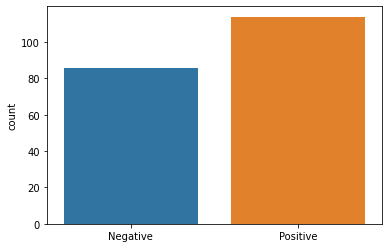

In [31]:

sns.countplot(sentiment)


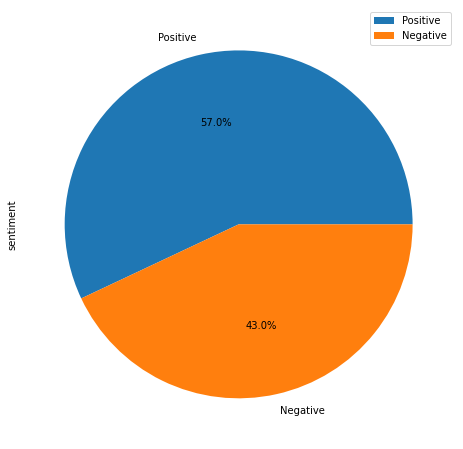

In [32]:
df_m["sentiment"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

In [33]:
def preprocess_text(sen):
    
   
    sentence = remove_tags(sen) 
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [34]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [35]:
X = []
sentences = list(df_m['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [36]:
y = df_m['sentiment_val']



In [37]:
df_f = df_f.iloc[:,2:]

In [38]:
df_f["text"] = X

In [51]:
df_f.head()

,neg,neu,pos,compound,text
0,0.303,0.697,0.000,-0.7500,is upset that he can update his Facebook by te...
1,0.000,0.833,0.167,0.4939,Kenichan dived many times for the ball Manage...
2,0.321,0.500,0.179,-0.2500,my whole body feels itchy and like its on fire
3,0.241,0.759,0.000,-0.6597,nationwideclass no it not behaving at all m m...
4,0.000,1.000,0.000,0.0000,Kwesidei not the whole crew


# Lets train our model now

In [52]:
# Train _ Test _ split _ validate
X_train, X_test, y_train, y_test = train_test_split(df_f, y, test_size=0.30)



In [53]:
'''
#word cleaning , tokenize
#Sentence Clean
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train.text)
#X_train,Xtest tokenize
X_train.text = tokenizer.texts_to_sequences(X_train.text)
X_test.test = tokenizer.texts_to_sequences(X_test.text)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train.text = pad_sequences(X_train.text, padding='post', maxlen=maxlen)
X_test.text = pad_sequences(X_test.text, padding='post', maxlen=maxlen)
'''

"\n#word cleaning , tokenize\n#Sentence Clean\ntokenizer = Tokenizer(num_words=5000)\ntokenizer.fit_on_texts(X_train.text)\n#X_train,Xtest tokenize\nX_train.text = tokenizer.texts_to_sequences(X_train.text)\nX_test.test = tokenizer.texts_to_sequences(X_test.text)\nvocab_size = len(tokenizer.word_index) + 1\n\nmaxlen = 50\n\nX_train.text = pad_sequences(X_train.text, padding='post', maxlen=maxlen)\nX_test.text = pad_sequences(X_test.text, padding='post', maxlen=maxlen)\n"

In [54]:
X_train

,neg,neu,pos,compound,text
102,0.000,1.000,0.000,0.0000,watching quot House quot
28,0.185,0.618,0.197,0.0534,Meh Almost Lover is the exception this track g...
85,0.216,0.784,0.000,-0.2960,msdrama hey missed ya at the meeting sup mama
53,0.000,0.244,0.756,0.4767,I need hug
107,0.000,1.000,0.000,0.0000,Henkuyinepu it overrated
...,...,...,...,...,...
196,0.000,1.000,0.000,0.0000,Is not going to sleep tonite
167,0.190,0.293,0.517,0.4995,marieclr was serious LOL
92,0.186,0.579,0.235,0.1280,pray for me please the ex is threatening to st...
189,0.221,0.779,0.000,-0.6597,I activated my Selfcontrol block early meaning...


<AxesSubplot:xlabel='sentiment_val', ylabel='count'>

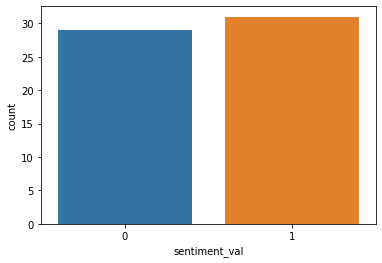

In [55]:
sns.countplot(y_test)

# Text vectorizer

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf= TfidfVectorizer(analyzer='word', stop_words='english', norm='l2')




In [57]:
tf.fit_transform(X)

<200x903 sparse matrix of type '<class 'numpy.float64'>'
	with 1344 stored elements in Compressed Sparse Row format>

In [58]:
X_train_ =tf.transform(X_train['text'])
X_test_= tf.transform(X_test['text'])

In [59]:
X_test_.shape

(60, 903)

In [60]:
#X_train = pad_sequences(X_train, maxlen=maxlen)

In [61]:
X_train = X_train_.toarray()

In [62]:
X_test = X_test_.toarray()

In [63]:
y_test

29     0
117    1
69     0
174    1
97     1
133    1
14     1
101    1
86     0
172    0
124    0
25     0
21     1
150    1
103    0
135    0
44     1
123    0
74     1
55     0
121    1
56     1
35     0
169    0
96     1
54     1
186    0
173    1
153    0
32     1
24     0
155    0
128    0
94     0
13     1
119    0
42     1
2      0
39     1
36     0
184    0
141    1
113    1
179    0
52     1
146    0
159    1
19     1
1      1
63     1
43     0
99     0
46     1
62     0
34     0
80     0
106    1
144    1
98     1
37     1
Name: sentiment_val, dtype: object

# Deep Belief Network Classifier

In [64]:

# Training DBN classifier 
classifier = SupervisedDBNClassification(hidden_layers_structure=[256, 256],
                                         learning_rate_rbm=0.05,
                                         learning_rate=0.1,
                                         n_epochs_rbm=10,
                                         n_iter_backprop=100,
                                         batch_size=7,
                                         activation_function='relu',
                                         dropout_p=0.2)

classifier.fit(X_train, y_train)

# Save the model
classifier.save('model.pkl')

# Restore it
#classifier = SupervisedDBNClassification.load('model.pkl')



[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.981605
>> Epoch 2 finished 	RBM Reconstruction error 0.980903
>> Epoch 3 finished 	RBM Reconstruction error 0.980728
>> Epoch 4 finished 	RBM Reconstruction error 0.980476
>> Epoch 5 finished 	RBM Reconstruction error 0.980486
>> Epoch 6 finished 	RBM Reconstruction error 0.980428
>> Epoch 7 finished 	RBM Reconstruction error 0.980262
>> Epoch 8 finished 	RBM Reconstruction error 0.980051
>> Epoch 9 finished 	RBM Reconstruction error 0.980083
>> Epoch 10 finished 	RBM Reconstruction error 0.979977
>> Epoch 1 finished 	RBM Reconstruction error 0.003909
>> Epoch 2 finished 	RBM Reconstruction error 0.004310
>> Epoch 3 finished 	RBM Reconstruction error 0.004380
>> Epoch 4 finished 	RBM Reconstruction error 0.004584
>> Epoch 5 finished 	RBM Reconstruction error 0.004498
>> Epoch 6 finished 	RBM Reconstruction error 0.004630
>> Epoch 7 finished 	RBM Reconstruction error 0.004710
>> Epoch 8 finished 	RBM Reconstructi

# predictions

In [65]:
# Test
Y_pred = classifier.predict(X_test)
print('Done.\nAccuracy: %f' % accuracy_score(y_test, Y_pred))
Y_pred


Done.
Accuracy: 0.516667


['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1']

# Confusion matrix

In [66]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,Y_pred)
print('Confusion Matrix of DBN \n\n', cm)

Confusion Matrix of DBN 

 [[ 0 29]
 [ 0 31]]


# Precision, Recall, F1 

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.52      1.00      0.68        31

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60





# Multi-layer NN

In [68]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

In [69]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [70]:
# Test
Y_pred = clf.predict(X_test)
print('Done.\nAccuracy: %f' % accuracy_score(y_test, Y_pred))
Y_pred


Done.
Accuracy: 0.500000


array(['0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0',
       '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '1', '1', '1', '1', '1'], dtype='<U1')

In [71]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,Y_pred)
print('Confusion Matrix of DBN \n\n', cm)

Confusion Matrix of DBN 

 [[ 3 26]
 [ 4 27]]


In [72]:
from sklearn.metrics import classification_report, confusion_matrix

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.43      0.10      0.17        29
           1       0.51      0.87      0.64        31

    accuracy                           0.50        60
   macro avg       0.47      0.49      0.40        60
weighted avg       0.47      0.50      0.41        60



